In [1]:
import random

import numpy as np
import pandas as pd

from dataset import get_dataset
from trainer import Trainer
from loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
## hyperparameters

model_name = 'efficientnet-b0'
batch_size = 64
lr = 0.000025
num_epoch = 40
target = 'mask'
split = 20

df_train_path = f'df/df_mask_gender_train_{split}.csv'
df_valid_path = f'df/df_mask_gender_valid_{split}.csv'
df_test_path = '/opt/ml/input/data/eval/info.csv'

In [4]:
## prepare dataset

df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)
df_test = pd.read_csv(df_test_path)

train_dataset, valid_dataset, test_dataset = get_dataset(df_train, df_valid, df_test, target=target)

In [5]:
## prepare sampler

from torch.utils.data.sampler import WeightedRandomSampler

target = train_dataset.target
weight = df_train[target].value_counts().sort_index().to_numpy()
print('count :', weight)
weight = 1. / weight
samples_weight = np.array([weight[t] for t in df_train[target]])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)//2)

count : [10800  2160  2160]


In [6]:
## prepare Dataloader

dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size, num_workers=3, drop_last=True, sampler=sampler),
               'valid' : DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=3, drop_last=False)}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3, drop_last=False)

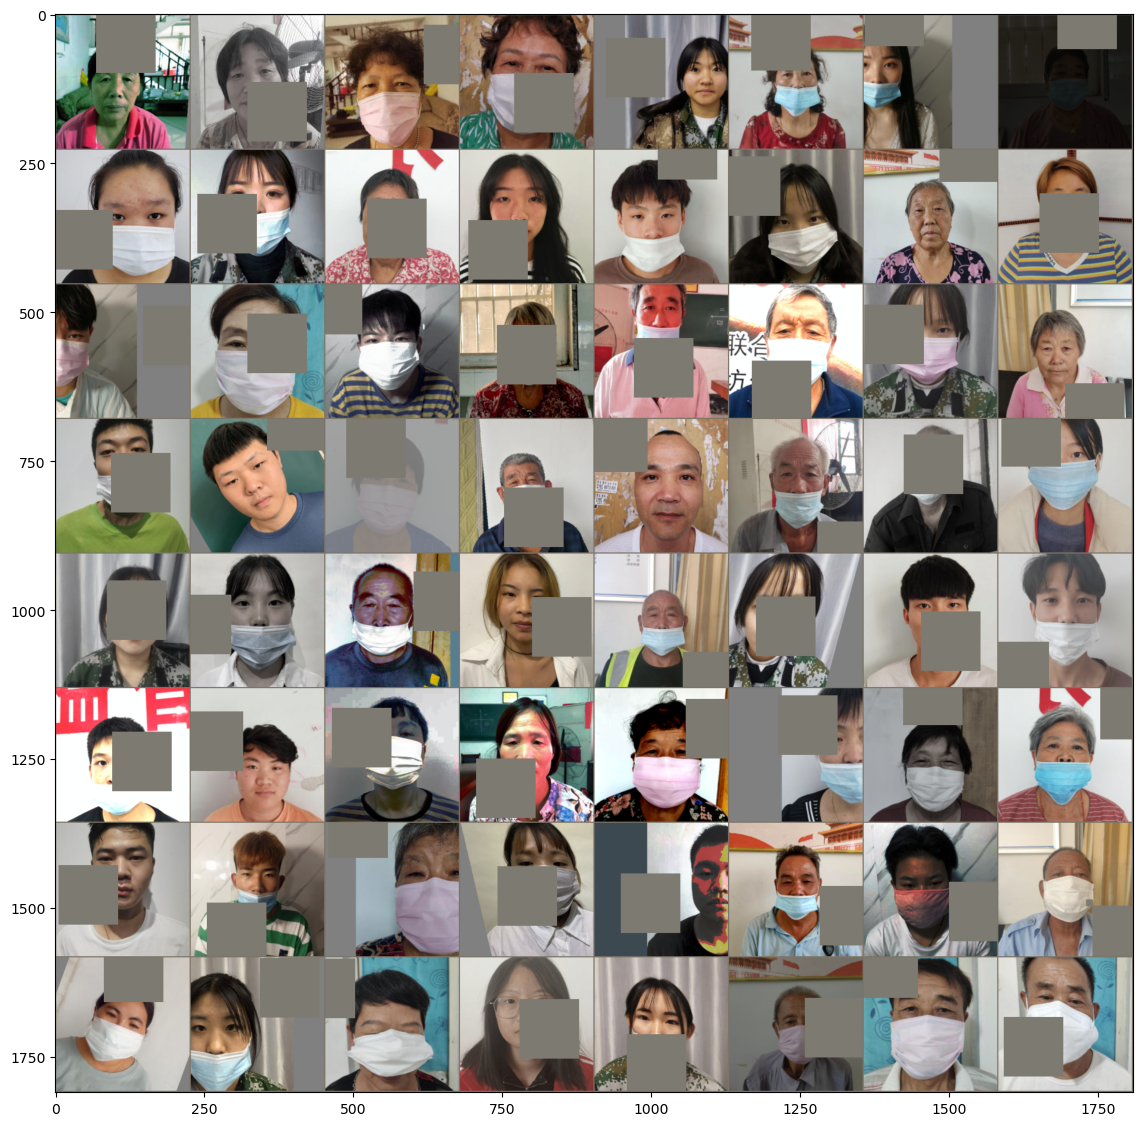

tensor([2, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 2,
        1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 1, 0, 1,
        2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0])


In [7]:
# check input train batch

from utils import imshow
batch = next(iter(dataloaders['train']))
imshow(batch[0])
print(batch[1])

In [8]:
## prepare model

device = 'cuda'

if model_name.startswith('efficientnet'):
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained(model_name, num_classes=len(train_dataset.classes))
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))

model.to(device)
print(model_name, 'ready')

Loaded pretrained weights for efficientnet-b0
efficientnet-b0 ready


In [9]:
criterion = LabelSmoothing(0.05)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = None #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma = 0.2)

## Train

In [10]:
trainer = Trainer('/opt/ml/code/save')

In [11]:
## resume
# model.load_state_dict(torch.load('/opt/ml/code/save/label/effnet_test018.pt'))

# # change lr manually:
# for g in optimizer.param_groups:
#     g['lr'] = 0.00001

In [12]:
trainer.train(model, dataloaders, criterion, optimizer, device, num_epochs=num_epoch, scheduler=lr_scheduler,
              sub_dir='mask', save_name='split_ratio_20_')

Epoch 1/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.64it/s]


train Loss: 0.8426 Acc: 0.7082 F1: 0.7082082222079286


100%|██████████| 60/60 [00:07<00:00,  7.70it/s]


valid Loss: 0.4102 Acc: 0.9429 F1: 0.9263813462770972

Epoch 2/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.57it/s]


train Loss: 0.4499 Acc: 0.8908 F1: 0.8910972625040429


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.2253 Acc: 0.9799 F1: 0.9717592943326885

Epoch 3/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


train Loss: 0.3297 Acc: 0.9284 F1: 0.9283892313074907


100%|██████████| 60/60 [00:07<00:00,  7.65it/s]


valid Loss: 0.1966 Acc: 0.9905 F1: 0.98592735850138

Epoch 4/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


train Loss: 0.2982 Acc: 0.9408 F1: 0.9407768207102359


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.1900 Acc: 0.9934 F1: 0.9905143885665709

Epoch 5/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


train Loss: 0.2760 Acc: 0.9509 F1: 0.950807358080366


100%|██████████| 60/60 [00:07<00:00,  7.61it/s]


valid Loss: 0.1884 Acc: 0.9952 F1: 0.9933822403022927

Epoch 6/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.61it/s]


train Loss: 0.2791 Acc: 0.9477 F1: 0.9477616508197592


100%|██████████| 60/60 [00:07<00:00,  7.60it/s]


valid Loss: 0.1848 Acc: 0.9963 F1: 0.994845304590679

Epoch 7/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.48it/s]


train Loss: 0.2614 Acc: 0.9584 F1: 0.9583018378440094


100%|██████████| 60/60 [00:07<00:00,  7.62it/s]


valid Loss: 0.1863 Acc: 0.9955 F1: 0.9937635774239465

Epoch 8/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


train Loss: 0.2590 Acc: 0.9588 F1: 0.9584977380640344


100%|██████████| 60/60 [00:07<00:00,  7.72it/s]


valid Loss: 0.1820 Acc: 0.9976 F1: 0.9966789526058862

Epoch 9/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


train Loss: 0.2565 Acc: 0.9576 F1: 0.9576811264397128


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.1829 Acc: 0.9971 F1: 0.9959469079052526

Epoch 10/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.62it/s]


train Loss: 0.2477 Acc: 0.9641 F1: 0.9640581809849453


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.1805 Acc: 0.9979 F1: 0.9970457821702013

Epoch 11/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


train Loss: 0.2490 Acc: 0.9616 F1: 0.9615660822757022


100%|██████████| 60/60 [00:07<00:00,  7.62it/s]


valid Loss: 0.1807 Acc: 0.9974 F1: 0.9963072277127516

Epoch 12/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.65it/s]


train Loss: 0.2476 Acc: 0.9629 F1: 0.9628860934766746


100%|██████████| 60/60 [00:07<00:00,  7.73it/s]


valid Loss: 0.1789 Acc: 0.9976 F1: 0.9966641951281119

Epoch 13/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.63it/s]


train Loss: 0.2472 Acc: 0.9641 F1: 0.9641143084027058


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.1787 Acc: 0.9976 F1: 0.99666913340412

Epoch 14/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.58it/s]


train Loss: 0.2410 Acc: 0.9672 F1: 0.9669855911981088


100%|██████████| 60/60 [00:07<00:00,  7.62it/s]


valid Loss: 0.1780 Acc: 0.9981 F1: 0.9974131519665436

Epoch 15/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.56it/s]


train Loss: 0.2398 Acc: 0.9662 F1: 0.9662385297402926


100%|██████████| 60/60 [00:07<00:00,  7.70it/s]


valid Loss: 0.1773 Acc: 0.9981 F1: 0.9974016292403323

Epoch 16/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.56it/s]


train Loss: 0.2359 Acc: 0.9698 F1: 0.9697792473012395


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.1775 Acc: 0.9981 F1: 0.9974131519665436

Epoch 17/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.57it/s]


train Loss: 0.2364 Acc: 0.9689 F1: 0.9689600439320963


100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


valid Loss: 0.1778 Acc: 0.9979 F1: 0.9970457821702013

Epoch 18/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


train Loss: 0.2379 Acc: 0.9680 F1: 0.9678750996439102


100%|██████████| 60/60 [00:07<00:00,  7.67it/s]


valid Loss: 0.1774 Acc: 0.9979 F1: 0.9970414180921393

Epoch 19/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


train Loss: 0.2296 Acc: 0.9721 F1: 0.9719869824006211


100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


valid Loss: 0.1772 Acc: 0.9981 F1: 0.9974131519665436

Epoch 20/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.54it/s]


train Loss: 0.2360 Acc: 0.9677 F1: 0.9676322353712098


100%|██████████| 60/60 [00:07<00:00,  7.69it/s]


valid Loss: 0.1773 Acc: 0.9979 F1: 0.9970457821702013

Epoch 21/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


train Loss: 0.2295 Acc: 0.9731 F1: 0.9730569355184525


100%|██████████| 60/60 [00:07<00:00,  7.67it/s]


valid Loss: 0.1771 Acc: 0.9979 F1: 0.9970457821702013

Epoch 22/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.58it/s]


train Loss: 0.2284 Acc: 0.9706 F1: 0.9706917105788845


100%|██████████| 60/60 [00:07<00:00,  7.62it/s]


valid Loss: 0.1766 Acc: 0.9976 F1: 0.9966740525284129

Epoch 23/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.54it/s]


train Loss: 0.2380 Acc: 0.9656 F1: 0.9654953221355739


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.1786 Acc: 0.9976 F1: 0.9966789526058862

Epoch 24/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.53it/s]


train Loss: 0.2346 Acc: 0.9666 F1: 0.9666184278104678


100%|██████████| 60/60 [00:07<00:00,  7.70it/s]


valid Loss: 0.1768 Acc: 0.9979 F1: 0.9970414180921393

Epoch 25/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.55it/s]


train Loss: 0.2320 Acc: 0.9695 F1: 0.9694527240097836


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.1766 Acc: 0.9976 F1: 0.9966740525284129

Epoch 26/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


train Loss: 0.2221 Acc: 0.9756 F1: 0.9756999028151662


100%|██████████| 60/60 [00:07<00:00,  7.63it/s]


valid Loss: 0.1776 Acc: 0.9974 F1: 0.9963072277127516

Epoch 27/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.56it/s]


train Loss: 0.2251 Acc: 0.9722 F1: 0.9721086115402824


100%|██████████| 60/60 [00:07<00:00,  7.67it/s]


valid Loss: 0.1778 Acc: 0.9979 F1: 0.9970501293641186

Epoch 28/40
----------


 96%|█████████▌| 113/118 [00:31<00:01,  3.56it/s]


KeyboardInterrupt: 

## Mask Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 21)
      - train Loss: 0.2192 Acc: 0.9767 F1: 0.9766713917541754
      - valid Loss: 0.1739 Acc: 0.9989 F1: 0.9985207090460696
        

## Gender Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 18)
      - train Loss: 0.1446 Acc: 0.9881 F1: 0.9880777974235919
      - valid Loss: 0.1551 Acc: 0.9854 F1: 0.9846651730146876
        
2. model=eff b0, optimizer=Adam, lr=0.0003, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 15)
      - train Loss: 0.1371 Acc: 0.9911 F1: 0.9911258239235885
      - valid Loss: 0.1574 Acc: 0.9868 F1: 0.9860680087572518


## Age & Gender Experiment Logs

---

### loss function test

---

1. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=CE, WeightedSampler, split 25%, optimizer=Adam
   * epoch 18)
     - train Loss: 0.0991 Acc: 0.9655 F1: 0.9654261306812848
     - valid Loss: 0.0980 Acc: 0.9778 F1: 0.9772288369633227  
  * before first patience

---

2. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=LS(0.05), WeightedSampler, split 25%, optimizer=Adam
    * epoch 21)
     - train Loss: 0.3310 Acc: 0.9638 F1: 0.963728513759618
     - valid Loss: 0.3071 Acc: 0.9786 F1: 0.9791634664746235 

---

3. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=F1_Loss, split 25%, optimizer=Adam
   * epoch 13)
     - train Loss: 0.0710 Acc: 0.9584 F1: 0.9476713834498373
     - valid Loss: 0.0403 Acc: 0.9765 F1: 0.9748789208889367
   * epoch 3)
     - train Loss: 0.0594 Acc: 0.9655 F1: 0.9555452013464937
     - valid Loss: 0.0369 Acc: 0.9782 F1: 0.9776768545260203

---

### split ratio test

---

4. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 15%
    * epoch 21)
      - train Loss: 0.3381 Acc: 0.9597 F1: 0.9597144587078792
      - valid Loss: 0.2948 Acc: 0.9852 F1: 0.982564296238198
      
---

5. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 27)
      - train Loss: 0.3211 Acc: 0.9668 F1: 0.9668728849468181
      - valid Loss: 0.2878 Acc: 0.9854 F1: 0.9842203787970396
      
---

6. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 25%
    * epoch 22)
      - train Loss: 0.3321 Acc: 0.9639 F1: 0.9638739223128628
      - valid Loss: 0.2910 Acc: 0.9829 F1: 0.9792575649184908
      
---

7. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 30%
    * epoch 29)
      - train Loss: 0.3171 Acc: 0.9686 F1: 0.9685813478405522
      - valid Loss: 0.3047 Acc: 0.9772 F1: 0.9764751322879572

## Debug

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
wrong = []
for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        
        for p, t, inp in zip(preds, labels, inputs):
            if p.item() != t.item():
                wrong.append((inp.cpu().numpy(), p.item(), t.item()))

mtx = confusion_matrix(y_true, y_pred)
print(mtx)


In [ ]:
import matplotlib.pyplot as plt

label_ = list(range(6))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
iterator = iter(wrong)

label = ["Male with mask", "Female with Mask", "Male incorrect mask", "Female no mask", "Male incorrect mask", "Female no mask"]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax in axes.flatten():
    img, p, t = next(iterator)
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()

## Inference

In [ ]:
def sum_label(df):
    
    def _label(row):
        return row['age'] + 3*row['label']# + 6*row['mask']

    df['ans'] = df.apply(_label, axis=1)
    return df[['ImageID', 'ans']]

In [ ]:
## inference

# model.load_state_dict(torch.load('/opt/ml/code/save/best_log2.pt'))
# df_submit = create_label(model, test_dataloader, df_test.copy(), device, target='label')

# model = EfficientNet.from_pretrained(model_name, num_classes=3).to(device)
# model.load_state_dict(torch.load('/opt/ml/code/save/age/extended_far_best.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='age')

# model.load_state_dict(torch.load('/opt/ml/code/save/mask/6e5_9987.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='mask')

# model.fc = nn.Linear(model.fc.in_features, 2).cuda()
# model.load_state_dict(torch.load('/opt/ml/code/save/gender/6e5_9851.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='gender')


# df_submit = sum_label(df_submit)
# df_submit


df_submit.to_csv('submit.csv', index=False)